In [1]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))

In [2]:
import numpy as np 
import scipy.fft
from operators.setup_FOM import SimulationSetupFOM
from operators.poisson_solver import gmres_solver
from operators.FOM import psi_ln_aw, charge_density, total_mass, total_momentum, total_energy_k

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
from mycolorpy import colorlist as mcp
import matplotlib
font = {'family' : 'serif',
        'size'   : 14}

matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 

## current driven ion acoustic instability

In [5]:
    setup = SimulationSetupFOM(Nx=301,
                               Nv=350,
                               epsilon=0.05,
                               alpha_e=np.sqrt(2),
                               alpha_i=1,
                               u_e=3,
                               u_i=0,
                               L=10,
                               dt=1e-2,
                               T0=0,
                               T=30,
                               nu=20,
                               m_e=1,
                               m_i=1,
                               ions=True,
                               construct_B=False)

In [6]:
# velocity grid for plotting purposes
v = np.linspace(-6, 6, int(1000), endpoint=True)
# spatial grid for plotting purposes
x = np.linspace(0, setup.L, setup.Nx+1, endpoint=True)

# simulation results

In [7]:
skip = 10
# load the simulation results
# save results
sol_midpoint_u = np.load("../data/FOM/ion_acoustic/sample_" + str(setup.u_e) + "/sol_FOM_u_" + str(setup.Nv) + "_u_e_" + str(setup.u_e) + "_" + str(setup.T0) + "_" + str(setup.T) + ".npy")[:, ::skip]
sol_midpoint_t = np.load("../data/FOM/ion_acoustic/sample_" + str(setup.u_e) + "/sol_FOM_t_" + str(setup.Nv) + "_u_e_" + str(setup.u_e) + "_" + str(setup.T0) + "_" + str(setup.T) + ".npy")[::skip]

dt = 0.01 * skip

# print simulation dimensions
print(np.shape(sol_midpoint_u))
print(np.shape(sol_midpoint_t))

(210700, 301)
(301,)


In [8]:
runtime = np.load("../data/FOM/ion_acoustic/sample_" + str(setup.u_e) + "/sol_FOM_u_" + str(setup.Nv) + "_u_e_" + str(setup.u_e) + "_runtime_" + str(setup.T0) + "_" + str(setup.T) + ".npy")
runtime

array([27597.464713  ,  3799.16042805])

In [9]:
# initialize the states for implicit midpoint (symplectic)
state_e_midpoint = np.zeros((setup.Nv,  setup.Nx + 1, len(sol_midpoint_t)))
state_i_midpoint = np.zeros((setup.Nv,  setup.Nx + 1, len(sol_midpoint_t)))
# initialize the electric potential
E_midpoint = np.zeros((setup.Nx + 1, len(sol_midpoint_t)))

for ii in np.arange(0, len(sol_midpoint_t)):
    print("time = ", sol_midpoint_t[ii])
    for n in range(setup.Nv):
        # unwind the flattening to solve the Vlasov-Poisson system
        # electrons
        state_e_midpoint[n, :-1, ii]  = sol_midpoint_u[n*setup.Nx: (n+1)*setup.Nx, ii]
        state_e_midpoint[n, -1, ii] = state_e_midpoint[n, 0, ii]
        # ions
        state_i_midpoint[n, :-1, ii] = sol_midpoint_u[setup.N + n*setup.Nx: setup.N + (n+1)*setup.Nx, ii]
        state_i_midpoint[n, -1, ii] = state_i_midpoint[n, 0, ii]
        
    # solve Poisson's equation to obtain an electric field
    rho = charge_density(alpha_e=setup.alpha_e, alpha_i=setup.alpha_i, q_e=setup.q_e, q_i=setup.q_i,
                         C0_e=state_e_midpoint[0, :setup.Nx, ii], C0_i=state_i_midpoint[0, :setup.Nx, ii])
    
    E_midpoint[:-1, ii] = gmres_solver(rhs=rho, D=setup.D, D_inv=setup.D_inv, atol=1e-12, rtol=1e-12)
    E_midpoint[-1, ii] = E_midpoint[0, ii]

time =  0.0
time =  0.1
time =  0.2
time =  0.3
time =  0.4
time =  0.5
time =  0.6
time =  0.7000000000000001
time =  0.8
time =  0.9
time =  1.0
time =  1.1
time =  1.2
time =  1.3
time =  1.4000000000000001
time =  1.5
time =  1.6
time =  1.7
time =  1.8
time =  1.9000000000000001
time =  2.0
time =  2.1
time =  2.2
time =  2.3000000000000003
time =  2.4
time =  2.5
time =  2.6
time =  2.7
time =  2.8000000000000003
time =  2.9
time =  3.0
time =  3.1
time =  3.2
time =  3.3000000000000003
time =  3.4
time =  3.5
time =  3.6
time =  3.7
time =  3.8000000000000003
time =  3.9
time =  4.0
time =  4.1
time =  4.2
time =  4.3
time =  4.4
time =  4.5
time =  4.6000000000000005
time =  4.7
time =  4.8
time =  4.9
time =  5.0
time =  5.1000000000000005
time =  5.2
time =  5.3
time =  5.4
time =  5.5
time =  5.6000000000000005
time =  5.7
time =  5.8
time =  5.9
time =  6.0
time =  6.1000000000000005
time =  6.2
time =  6.3
time =  6.4
time =  6.5
time =  6.6000000000000005
time =  6.7
time

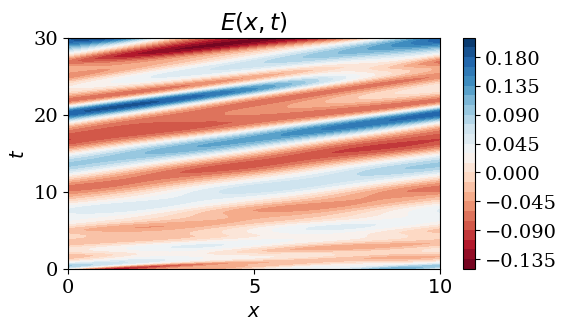

In [10]:
# plot the electric field
fig, ax = plt.subplots(figsize=(6, 3))
pos = ax.contourf(x, sol_midpoint_t, E_midpoint.T, cmap="RdBu", levels=30)
cbar = fig.colorbar(pos)
ax.set_title("$E(x, t)$")
ax.set_xlabel("$x$")
_ = ax.set_xticks([0, 5, 10])
_ = ax.set_xticklabels([r"0", r"$5$", r"$10$"])
_ = ax.set_ylabel("$t$")

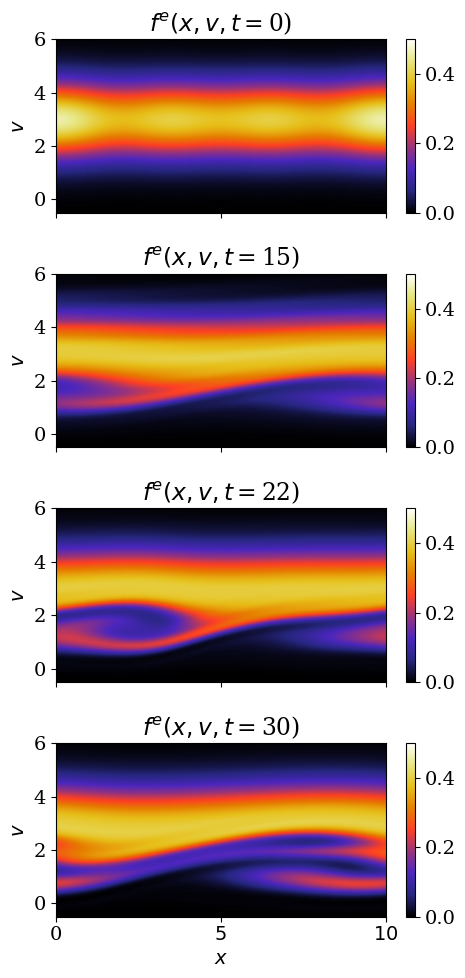

In [11]:
# plot the phase space evolution as a function of time
fig, ax = plt.subplots(nrows=4, figsize=(5, 10), sharex=True)
for tt, ii in enumerate([0, int(len(sol_midpoint_t)//2), int(3*len(sol_midpoint_t)//4), -1]):
    ii = int(ii)
    distribution_e = np.zeros((len(x), len(v)))
    distribution_p = np.zeros((len(x), len(v)))
    for jj in range(setup.Nv):
        distribution_e += np.outer(state_e_midpoint[jj, :, ii], psi_ln_aw(v=v, u_s=setup.u_e, alpha_s=setup.alpha_e, n=jj))
        distribution_p += np.outer(state_i_midpoint[jj, :, ii], psi_ln_aw(v=v, u_s=setup.u_i, alpha_s=setup.alpha_i, n=jj))
    pos = ax[tt].pcolormesh(x, v, (distribution_e).T, cmap="CMRmap", shading="gouraud", vmin=0, vmax=0.5)
    ax[tt].set_yticks([0, 2, 4, 6])
    ax[tt].set_ylim(-0.5, 6)
    ax[tt].set_ylabel("$v$")
    cbar = fig.colorbar(pos)
    #cbar.ax.set_yticks([0,  0.2, 0.4, 0.6])
    ax[tt].set_title("$f^{e}(x, v, t=$" + str(int(sol_midpoint_t[ii])) + ")")

ax[tt].set_xlabel("$x$")
ax[tt].set_xticks([0, 5, 10])
ax[tt].set_xticklabels([r"0", r"$5$", r"$10$"])
plt.tight_layout()
plt.savefig("../figs/FOM/ion_acoustic/ion_acoustic_electron_evolution_" + str(setup.u_e) +".png", dpi=200)

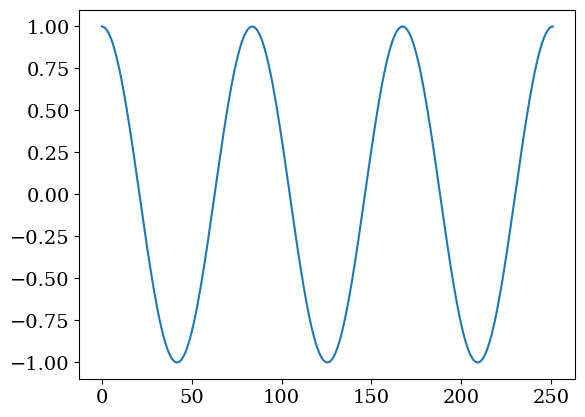

In [155]:
#_= plt.plot(state_e_midpoint[0, :, 0])
_ = plt.plot(( np.cos(x * 6 * np.pi / 10) ))

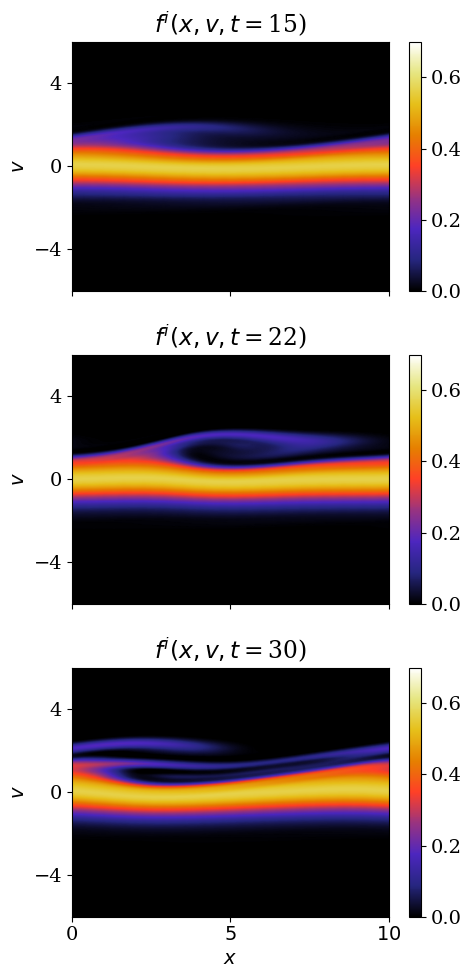

In [12]:
# plot the phase space evolution as a function of time
fig, ax = plt.subplots(nrows=3, figsize=(5, 10), sharex=True)
for tt, ii in enumerate([int(len(sol_midpoint_t)//2), int(3*len(sol_midpoint_t)//4), -1]):
    ii = int(ii)
    distribution = np.zeros((len(x), len(v)))
    for jj in range(setup.Nv):
        distribution += np.outer(state_i_midpoint[jj, :, ii], psi_ln_aw(v=v, u_s=setup.u_i, alpha_s=setup.alpha_i, n=jj))
    pos = ax[tt].pcolormesh(x, v, distribution.T, cmap="CMRmap", shading="gouraud", vmin=0, vmax=0.7)
    ax[tt].set_yticks([-4, 0, 4])
    ax[tt].set_ylabel("$v$")
    cbar = fig.colorbar(pos)
    #cbar.ax.set_yticks([0,  0.2, 0.4, 0.6])
    ax[tt].set_title("$f^{i}(x, v, t=$" + str(int(sol_midpoint_t[ii])) + ")")

ax[tt].set_xlabel("$x$")
ax[tt].set_xticks([0, 5, 10])
ax[tt].set_xticklabels([r"0", r"$5$", r"$10$"])
plt.tight_layout()
plt.savefig("../figs/FOM/ion_acoustic/ion_acoustic_ion_evolution_" + str(setup.u_e) +".png", dpi=200)

In [13]:
# compute the electric field k=1 mode amplitude using fft
E1_midpoint = np.zeros(len(sol_midpoint_t))

for ii in range(len(sol_midpoint_t)):
    E1_midpoint[ii] = np.abs(scipy.fft.fft(E_midpoint[:-1, ii]))[1]/setup.Nx

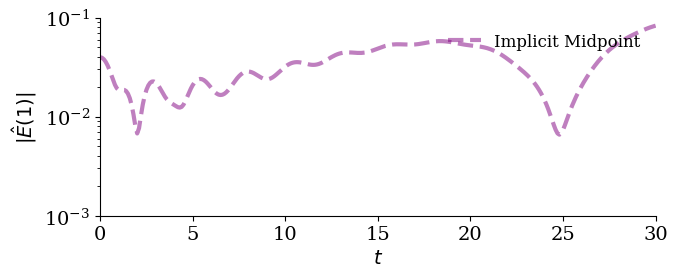

In [14]:
# plot the electric field damping rate
fig, ax = plt.subplots(figsize=(7, 3))
ax.plot(sol_midpoint_t, E1_midpoint, "--", c="purple", alpha=0.5, linewidth=3, label="Implicit Midpoint") 

ax.set_yscale("log")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel("$|\hat{E}(1)|$")
ax.set_xlabel("$ t$")
ax.set_xlim(0, setup.T)
ax.set_ylim(1e-3, 1e-1)
legend = ax.legend(ncols=1, fancybox=False, shadow=False, fontsize=12, loc='upper right')
legend.get_frame().set_alpha(0)
plt.tight_layout()
#plt.savefig("../figs/FOM/ion_acoustic/electric_field_growth_rate_" + str(setup.Nv) + ".png", dpi=600)

In [15]:
# save the electric field
# np.save("../data/FOM/linear_landau/sample_" + str(setup.alpha_e) + "/sol_midpoint_E_" + str(setup.Nv) + "_alpha_" + str(setup.alpha_e) + ".npy", E_midpoint)
# np.save("../data/FOM/linear_landau/sample_" + str(setup.alpha_e) + "/sol_midpoint_E1_" + str(setup.Nv) + "_alpha_" + str(setup.alpha_e) + ".npy", E1_midpoint)

# conservation laws: mass, momentum, and energy

### mass conservation

In [16]:
# compute mass at each timestamp
mass_midpoint = np.zeros(len(sol_midpoint_t))

for ii in range(0, len(sol_midpoint_t)):
    mass_midpoint[ii] = total_mass(state=state_e_midpoint[:, :-1, ii], alpha_s=setup.alpha_e, dx=setup.dx)\
                        +total_mass(state=state_i_midpoint[:, :-1, ii], alpha_s=setup.alpha_i, dx=setup.dx)

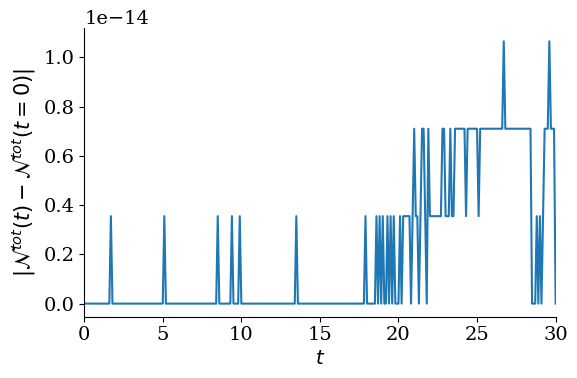

In [17]:
# plot mass conservation
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(sol_midpoint_t, np.abs(mass_midpoint - mass_midpoint[0]), "-")
#ax.set_yscale("log")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"$|\mathcal{N}^{tot}(t) - \mathcal{N}^{tot}(t=0)|$", fontsize=15)
ax.set_xlabel("$t$")
ax.set_xlim(setup.T0, setup.T)
plt.tight_layout()

### momentum conservation

In [18]:
# compute momentum at each timestamp
momentum_midpoint = np.zeros(len(sol_midpoint_t))

for ii in range(0, len(sol_midpoint_t)):
    momentum_midpoint[ii] = total_momentum(state=state_e_midpoint[:, :-1, ii], alpha_s=setup.alpha_e, dx=setup.dx, m_s=setup.m_e, u_s=setup.u_e)\
                            +total_momentum(state=state_i_midpoint[:, :-1, ii], alpha_s=setup.alpha_i, dx=setup.dx, m_s=setup.m_i, u_s=setup.u_i)

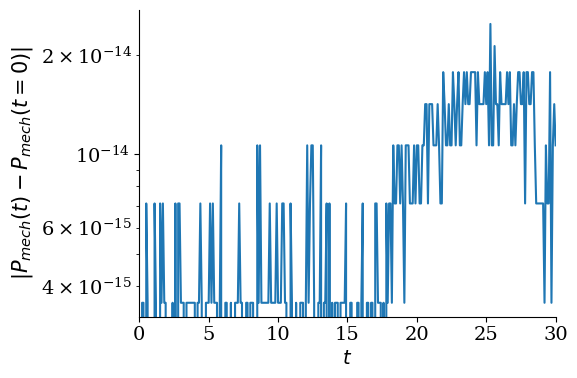

In [19]:
# plot momentum conservation
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(sol_midpoint_t, np.abs(momentum_midpoint - momentum_midpoint[0]), "-")
ax.set_yscale("log")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"$|P_{mech}(t)-P_{mech}(t=0)|$", fontsize=15)
ax.set_xlim(setup.T0, setup.T)
ax.set_xlabel("$t$")
plt.tight_layout()

### energy conservation

In [20]:
# compute energy (kinetic + potential) at each timestamp
energy_k_midpoint = np.zeros(len(sol_midpoint_t))
energy_p_midpoint = np.zeros(len(sol_midpoint_t))

for ii in range(0, len(sol_midpoint_t)):
    energy_k_midpoint[ii] = total_energy_k(state=state_e_midpoint[:, :-1, ii], alpha_s=setup.alpha_e, dx=setup.dx, m_s=setup.m_e, u_s=setup.u_e)\
                           +total_energy_k(state=state_i_midpoint[:, :-1, ii], alpha_s=setup.alpha_i, dx=setup.dx, m_s=setup.m_i, u_s=setup.u_i)
    
    energy_p_midpoint[ii] = 0.5*setup.dx*np.sum((E_midpoint[:-1, ii])**2)

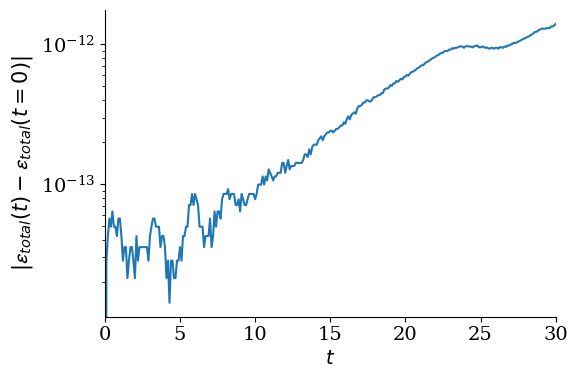

In [21]:
# plot energy conservation
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(sol_midpoint_t, np.abs(energy_p_midpoint + energy_k_midpoint -energy_p_midpoint[0]-energy_k_midpoint[0]), "-")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"$|\mathcal{\epsilon}_{total}(t)-\mathcal{\epsilon}_{total}(t=0)|$", fontsize=15)
ax.set_xlabel("$ t$")
ax.set_xlim(setup.T0, setup.T)
ax.set_yscale("log")
plt.tight_layout()

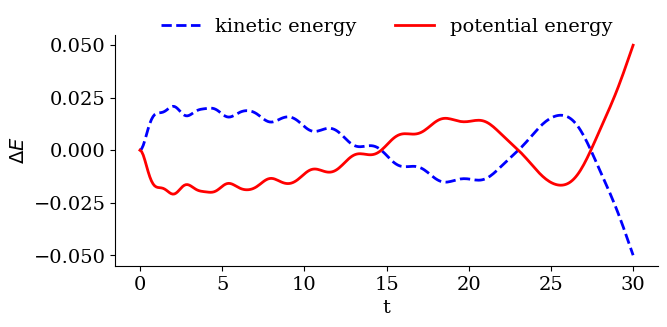

In [22]:
# plot the (kinetic + potential) energy exchange
fig, ax = plt.subplots(figsize=(7, 3))
plt.plot(sol_midpoint_t, energy_k_midpoint- energy_k_midpoint[0], label="kinetic energy", ls="--", linewidth=2, color="blue")
plt.plot(sol_midpoint_t, energy_p_midpoint- energy_p_midpoint[0], label="potential energy", linewidth=2, color="red")
legend = ax.legend(ncols=2, fontsize=14, loc='upper center', bbox_to_anchor=(0.5, 1.15))
legend.get_frame().set_alpha(0)
#ax.set_xlim(0, 100)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel("t")
_ = ax.set_ylabel(r"$\Delta E$")

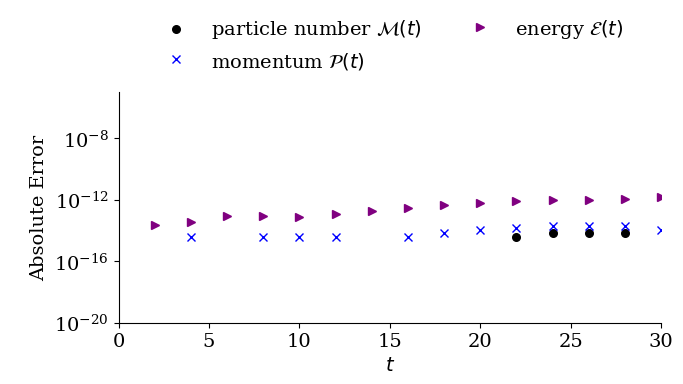

In [23]:
# plot the analytic and numerical conservation properties
fig, ax = plt.subplots(figsize=(7, 3))
ax.scatter(sol_midpoint_t[::20], np.abs(mass_midpoint-mass_midpoint[0])[::20], s=30, color="black", label=r"particle number $\mathcal{M}(t)$")
ax.plot(sol_midpoint_t[::20], np.abs(momentum_midpoint-momentum_midpoint[0])[::20], "x", color="blue", label=r"momentum $\mathcal{P}(t)$")
ax.plot(sol_midpoint_t[::20], np.abs(energy_p_midpoint + energy_k_midpoint -energy_p_midpoint[0]-energy_k_midpoint[0])[::20], ">", color="purple", label=r"energy $\mathcal{E}(t)$")
ax.set_ylim(10**-20, 10**-5)
ax.set_yscale("log")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"Absolute Error")
ax.set_xlabel("$t$")
ax.set_xlim(setup.T0, setup.T)
ax.set_yscale("log")
legend = ax.legend(ncols=2, fontsize=14, loc='upper center', bbox_to_anchor=(0.5, 1.4))
text = ax.text(-0.2,1.05, " ", transform=ax.transAxes)
legend.get_frame().set_alpha(0)
#plt.savefig("../figs/FOM/linear_landau/conservation_" + str(setup.Nv) + "_two_stream_FOM.png", bbox_extra_artists=(legend,text), bbox_inches='tight', dpi=600)